In [222]:
import pandas as pd
import river
from pprint import pprint
from river import compose
from river import linear_model
from river import metrics
from river import evaluate
from river import preprocessing
from river import optim
from river import feature_extraction
from river import stats
import itertools
import datetime as dt
from river import ensemble
from river import stream
from river import datasets
from river import facto
from river import compat
from river import tree
from river import neighbors
from river import multioutput
from river import neural_net
from river import dummy
from river import compat
from river import time_series
import numpy as np
import time
from tqdm import tqdm
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
%matplotlib inline

In [5]:
# caricamente dati volume idrico

path_idra = '/home/giodefa/PycharmProjects/Script_Tesi_new/Dati/Urban Water Demand Data.txt'

def load_idraulic_press_data(data_path):

       dati = pd.read_csv(path_idra, sep='\t', index_col=False, header=0, names=('date','00:00-00:59','01:00-01:59','02:00-02:59','03:00-03:59','04:00-04:59','05:00-05:59','06:00-06:59','07:00-07:59','08:00-08:59','09:00-09:59','10:00-10:59','11:00-11:59','12:00-12:59','13:00-13:59','14:00-14:59','15:00-15:59','16:00-16:59','17:00-17:59','18:00-18:59','19:00-19:59','20:00-20:59','21:00-21:59','22:00-22:59','23:00-23:59'))


       date = dati.date
       dati = dati.drop("date", axis= 1)

       dati = dati.stack().reset_index()

       list_date = []
       for i in date:
              for a in range(0,24):
                     list_date.append(i)

       list_hour = []
       i = 0
       for a in range(0,dati.shape[0]):
              list_hour.append(i)
              i +=1
              if(i == 24):
                     i=0


       dati['date'] = list_date

       dati = dati.rename(columns = {'level_0':'Count_days','level_1':'Hours',0:'Water_volume'})
       dati = dati[['Count_days','date','Hours','Water_volume']]


       dati['date'] = pd.to_datetime(dati['date'], format='%d-%m-%Y')


       dati['days'] = dati['date'].dt.day

       dati['month'] =  dati['date'].dt.month

       dati['hour'] =  list_hour

       return dati

dati = load_idraulic_press_data(path_idra)
dati.to_csv('dativolum.csv')

def initial_iter_idraulic():

       path = '/home/giodefa/PycharmProjects/Script_Tesi_new/Script/DatiTesi/dativolum.csv'

       X_y = stream.iter_csv(
              filepath_or_buffer=path,
              converters={
                     'Count_days': int,
                     'Water_volume': float,
                     'days': int,
                     'month': int,
                     'hour': int,
                     '': int
                     },
              parse_dates={'date': '%Y-%m-%d'},
              target='Water_volume'
                      )
       return X_y

/tmp/ipykernel_21293/3318043435.py:7: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dati = pd.read_csv(path_idra, sep='\t', index_col=False, header=0, names=('date','00:00-00:59','01:00-01:59','02:00-02:59','03:00-03:59','04:00-04:59','05:00-05:59','06:00-06:59','07:00-07:59','08:00-08:59','09:00-09:59','10:00-10:59','11:00-11:59','12:00-12:59','13:00-13:59','14:00-14:59','15:00-15:59','16:00-16:59','17:00-17:59','18:00-18:59','19:00-19:59','20:00-20:59','21:00-21:59','22:00-22:59','23:00-23:59'))


In [46]:
# caricamento dati power Consumption House

dati_test = pd.read_csv("/home/giodefa/PycharmProjects/Script_Tesi_new/Dati/HouseTwenty/HouseTwenty_TEST.txt", delim_whitespace=True, header=None)

dati_train = pd.read_csv("/home/giodefa/PycharmProjects/Script_Tesi_new/Dati/HouseTwenty/HouseTwenty_TRAIN.txt", delim_whitespace=True, header=None)

dati_train = dati_train.drop(0, axis= 1)
dati_test = dati_test.drop(0, axis= 1)

dati_train = dati_train.stack().reset_index()
dati_test = dati_test.stack().reset_index()

dati_train = dati_train.rename(columns = {'level_0':'Count_days','level_1':'Tick',0:'PowerConsumption'})
dati_train = dati_train[['Count_days','Tick','PowerConsumption']]

dati_test = dati_test.rename(columns = {'level_0':'Count_days','level_1':'Tick',0:'PowerConsumption'})
dati_test = dati_test[['Count_days','Tick','PowerConsumption']]


# concateno i due dataset almeno per quanto riguarda lo sviluppo di algoritmi online

dati_complete_twe = pd.concat([dati_train, dati_test])

dati_complete_twe = dati_complete_twe[['Count_days', 'Tick', 'PowerConsumption']]
dati_complete_twe.to_csv('dati_PowerConsumption_twe')


dati_complete_twe = pd.read_csv('/home/giodefa/PycharmProjects/Script_Tesi_new/Script/DatiTesi/dati_PowerConsumption_twe')



dati_complete_twe = dati_complete_twe[['Count_days', 'Tick', 'PowerConsumption']]
dati_complete_twe


def initial_iter_twe():

       path = '/home/giodefa/PycharmProjects/Script_Tesi_new/Script/DatiTesi/dati_PowerConsumption_twe'

       X_y = stream.iter_csv(
              filepath_or_buffer=path,
              converters={
                     'Count_days': int,
                     'PowerConsumption': float,
                     'Tick': int
                     },
              target='PowerConsumption'
                      )
       return X_y

In [47]:
# caricamento dati ItalyPowerDemand

dati_test = pd.read_csv("/home/giodefa/PycharmProjects/Script_Tesi_new/Dati/ItalyPowerDemand(1)/ItalyPowerDemand_TEST.txt",delim_whitespace=True, index_col=False, header=0, names=('target','00:00-00:59','01:00-01:59','02:00-02:59','03:00-03:59','04:00-04:59','05:00-05:59','06:00-06:59','07:00-07:59','08:00-08:59','09:00-09:59','10:00-10:59','11:00-11:59','12:00-12:59','13:00-13:59','14:00-14:59','15:00-15:59','16:00-16:59','17:00-17:59','18:00-18:59','19:00-19:59','20:00-20:59','21:00-21:59','22:00-22:59','23:00-23:59'))

dati_train = pd.read_csv("/home/giodefa/PycharmProjects/Script_Tesi_new/Dati/ItalyPowerDemand(1)/ItalyPowerDemand_TRAIN.txt", delim_whitespace=True, index_col=False, header=0, names=('target','00:00-00:59','01:00-01:59','02:00-02:59','03:00-03:59','04:00-04:59','05:00-05:59','06:00-06:59','07:00-07:59','08:00-08:59','09:00-09:59','10:00-10:59','11:00-11:59','12:00-12:59','13:00-13:59','14:00-14:59','15:00-15:59','16:00-16:59','17:00-17:59','18:00-18:59','19:00-19:59','20:00-20:59','21:00-21:59','22:00-22:59','23:00-23:59'))

dati_train = dati_train.drop("target", axis= 1)
dati_test = dati_test.drop("target", axis= 1)

dati_train = dati_train.stack().reset_index()
dati_test = dati_test.stack().reset_index()

dati_train = dati_train.rename(columns = {'level_0':'Count_days','level_1':'Hours',0:'PowerDemandValue'})
dati_train = dati_train[['Count_days','Hours','PowerDemandValue']]

dati_test = dati_test.rename(columns = {'level_0':'Count_days','level_1':'Hours',0:'PowerDemandValue'})
dati_test = dati_test[['Count_days','Hours','PowerDemandValue']]

# concateno i due dataset almeno per quanto riguarda lo sviluppo di algoritmi online

dati_complete_italy = pd.concat([dati_train, dati_test])
list_hour = []
i = 0
for a in range(0, dati_complete_italy.shape[0]):
       list_hour.append(i)
       i +=1
       if(i == 24):
              i=0
dati_complete_italy['hour'] = list_hour
dati_complete_italy = dati_complete_italy[['Count_days', 'hour', 'PowerDemandValue']]
dati_complete_italy.to_csv('dati_PowerDemandValue')


dati_complete_italy = pd.read_csv('/home/giodefa/PycharmProjects/Script_Tesi_new/Script/DatiTesi/dati_PowerDemandValue')



dati_complete_italy = dati_complete_italy[['Count_days', 'hour', 'PowerDemandValue']]
dati_complete_italy


def initial_iter_italy():

       path = '/home/giodefa/PycharmProjects/Script_Tesi_new/Script/DatiTesi/dati_PowerDemandValue'

       X_y = stream.iter_csv(
              filepath_or_buffer=path,
              converters={
                     'Count_days': int,
                     'PowerDemandValue': float,
                     'hour': int
                     },
              target='PowerDemandValue'
                      )
       return X_y

In [48]:
X_y_idraulic = initial_iter_idraulic()
X_y_italy = initial_iter_italy()
X_y_twe = initial_iter_twe()

In [49]:
next(X_y_idraulic)

({'': 0,
  'Count_days': 0,
  'date': datetime.datetime(2012, 10, 2, 0, 0),
  'Hours': '00:00-00:59',
  'days': 2,
  'month': 10,
  'hour': 0},
 13815.2)

In [50]:
next(X_y_italy)


({'': '0', 'Count_days': 0, 'hour': 0}, -0.99300935)

In [51]:
next(X_y_twe)

({'': '0', 'Count_days': 0, 'Tick': 1}, 349.0)

# MLPRegressor online vs batch

In [ ]:
# partiamo sicuramente dal modello MLP --> multi-layer perceptron
# quindi faremo un confronto diretto, utilizzando i tre dataframe che abbiamo in possesso
# per il confronto diretto metteremo in confronto il test, che sarà circa il 30 % delle nostre osservazioni in questo modo osserveremo i risultati solamente di quella parte e potremo fare un confronto mediante l'utilizzo delle metriche di MSE e MAE. Poi faremo una valutazione anche dal punto di vista della velocità punto fondamentale!

# quindi sicuramente i punti per il confronto saranno il test per i due casi.

## Water Volume Prediction

### MLP online

In [249]:
X_y = initial_iter_idraulic()
next(X_y)

({'': 0,
  'Count_days': 0,
  'date': datetime.datetime(2012, 10, 2, 0, 0),
  'Hours': '00:00-00:59',
  'days': 2,
  'month': 10,
  'hour': 0},
 13815.2)

In [18]:
8496/100*70

5947.2

100%|██████████| 8496/8496 [00:08<00:00, 1035.45it/s]


Execution time: 8.208051919937134 seconds


Text(0.5, 1.0, 'MSE: 12,709,253.218966')

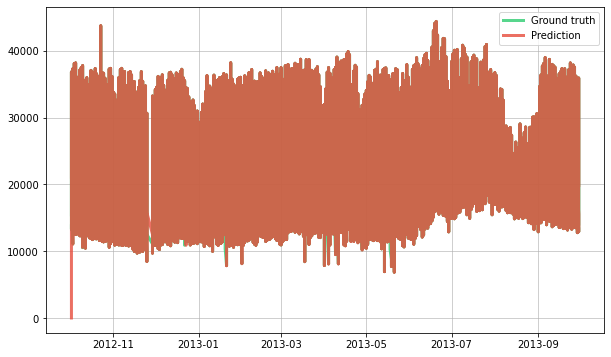

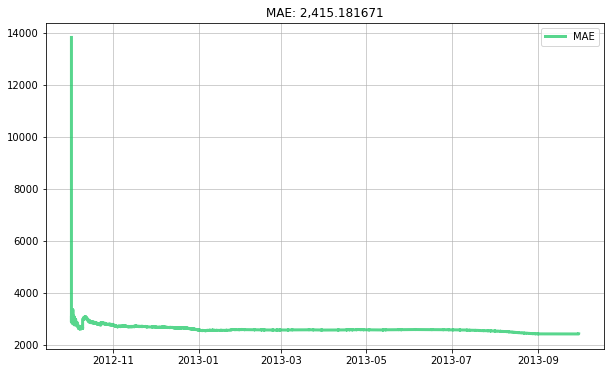

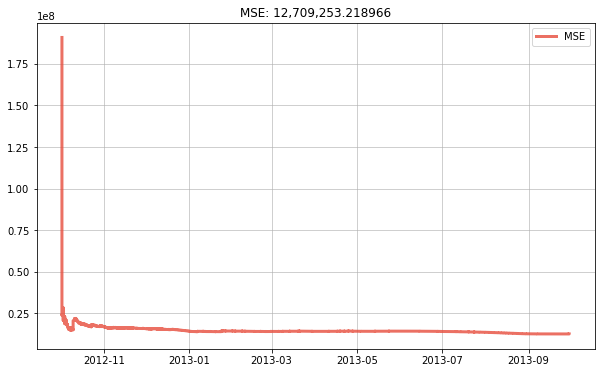

In [355]:
from river import metrics
import matplotlib.pyplot as plt


metric_mae = metrics.MAE()
metric_mse = metrics.MSE()

dates = []
y_trues = []
y_preds = []
metrics_MAE = []
metrics_MSE = []

X_y = initial_iter_idraulic()

model = compose.Select()
model |= (
       preprocessing.StandardScaler() |
       neural_net.MLPRegressor(
              hidden_dims=(8, 16),
              activations=(
                     neural_net.activations.ReLU,
                     neural_net.activations.ReLU,
                     neural_net.activations.Identity
              ),
              optimizer=optim.SGD(0.5),

       )
)

# get the start time
st = time.time()

for i in tqdm(range(0,8496)):  #8496
       x, y = next(X_y)
       # Obtain the prior prediction and update the model in one go
       y_pred = model.predict_one(x)
       model.learn_one(x, y)

       # Update the error metric ultimo 30%
       metric_mae.update(y, y_pred)
       metric_mse.update(y, y_pred)
       metrics_MAE.append(metric_mae.get())
       metrics_MSE.append(metric_mse.get())

       # Store the true value and the prediction
       dates.append(x['date'])
       y_trues.append(y)
       y_preds.append(y_pred)

et = time.time()

# get the execution time
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

# Plot the results
fig, ax = plt.subplots(figsize=(10, 6))
ax.grid(alpha=0.75)
ax.plot(dates, y_trues, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
ax.plot(dates, y_preds, lw=3, color='#e74c3c', alpha=0.8, label='Prediction')
ax.legend()

fig, ax = plt.subplots(figsize=(10, 6))
ax.grid(alpha=0.75)
ax.plot(dates, metrics_MAE, lw=3, color='#2ecc71', alpha=0.8, label='MAE')
ax.legend()
ax.set_title(metric_mae)


fig, ax = plt.subplots(figsize=(10, 6))
ax.grid(alpha=0.75)
ax.plot(dates, metrics_MSE, lw=3, color='#e74c3c', alpha=0.8, label='MSE')
ax.legend()
ax.set_title(metric_mse)

<BarContainer object of 1 artists>

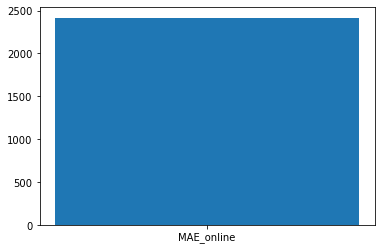

In [356]:
plt.bar(height=metrics_MAE[-1], x='MAE_online')

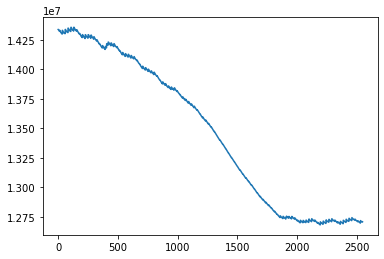

In [357]:
plt.plot(metrics_MSE[5947::])

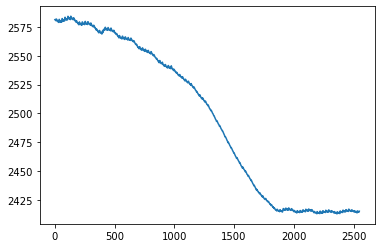

In [358]:
plt.plot(metrics_MAE[5947::], )

#### Progressive val score

In [369]:
X_y = initial_iter_idraulic()
model = compose.Select()
model |= (
       preprocessing.StandardScaler() |
       neural_net.MLPRegressor(
              hidden_dims=(8, 16),
              activations=(
                     neural_net.activations.ReLU,
                     neural_net.activations.ReLU,
                     neural_net.activations.Identity
              ),
              optimizer=optim.SGD(0.005),

       )
)

evaluate.progressive_val_score(
       dataset= X_y,
       model = model,
       metric = metrics.MAE(),
       moment='date',
       delay=dt.timedelta(hours=3),
       print_every=3000
)

[3,000] MAE: 7,141.944032
[6,000] MAE: 6,950.219517


MAE: 6,514.380636

### MLP batch

In [331]:

X = dati['Water_volume'].to_numpy()
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return X, y

# split into samples
X, y = split_sequence(X, 1)
# summarize the data
for i in range(len(X)):
	print(X[i], y[i])

[13815.2] 13290.0
[13290.] 13416.2
[13416.2] 13424.6
[13424.6] 14607.3
[14607.3] 21604.4
[21604.4] 36274.4
[36274.4] 36846.8
[36846.8] 34012.0
[34012.] 31996.7
[31996.7] 30772.6
[30772.6] 31212.0
[31212.] 31925.3
[31925.3] 31221.3
[31221.3] 28082.1
[28082.1] 26270.8
[26270.8] 26023.8
[26023.8] 28019.3
[28019.3] 31906.8
[31906.8] 32429.2
[32429.2] 27880.0
[27880.] 23147.9
[23147.9] 20957.8
[20957.8] 15324.4
[15324.4] 11078.6
[11078.6] 11697.2
[11697.2] 11279.2
[11279.2] 11198.1
[11198.1] 12768.4
[12768.4] 20138.0
[20138.] 34931.9
[34931.9] 37314.8
[37314.8] 34414.3
[34414.3] 31886.9
[31886.9] 30456.6
[30456.6] 30552.1
[30552.1] 31558.2
[31558.2] 30476.8
[30476.8] 27743.6
[27743.6] 26022.8
[26022.8] 25997.0
[25997.] 28242.3
[28242.3] 31042.9
[31042.9] 32205.7
[32205.7] 27964.7
[27964.7] 23597.8
[23597.8] 20851.1
[20851.1] 16044.3
[16044.3] 13771.8
[13771.8] 13011.6
[13011.6] 12756.0
[12756.] 12661.6
[12661.6] 13957.2
[13957.2] 21665.0
[21665.] 36087.8
[36087.8] 38116.9
[38116.9] 34242.8


In [323]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, random_state=1, train_size=0.7, shuffle=False)

In [242]:
X_train = X_train.to_numpy()
X_train = X_train.reshape(-1,1)
X_train.shape

#Y_train = Y_train.to_numpy()
#Y_train.reshape(1, -1)

AttributeError: 'list' object has no attribute 'to_numpy'

In [324]:
regr = MLPRegressor(random_state=1, max_iter=2000, verbose=True).fit(X_train, Y_train)

Iteration 1, loss = 163831362.10146463
Iteration 2, loss = 53706915.58331149
Iteration 3, loss = 13827390.22855980
Iteration 4, loss = 7311480.12132075
Iteration 5, loss = 7119755.31030216
Iteration 6, loss = 7117405.78481604
Iteration 7, loss = 7116511.79938295
Iteration 8, loss = 7116033.02626452
Iteration 9, loss = 7118520.63352359
Iteration 10, loss = 7118570.49094203
Iteration 11, loss = 7116653.52478760
Iteration 12, loss = 7117115.99092901
Iteration 13, loss = 7116447.84712972
Iteration 14, loss = 7117132.13258953
Iteration 15, loss = 7118384.46106182
Iteration 16, loss = 7116756.63091325
Iteration 17, loss = 7118647.19265197
Iteration 18, loss = 7117132.11225609
Iteration 19, loss = 7117408.32844577
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


In [235]:
X_test = X_test.to_numpy()
X_test = X_test.reshape(-1,1)

AttributeError: 'list' object has no attribute 'to_numpy'

In [326]:
result = regr.predict(X_test).reshape(-1,1)

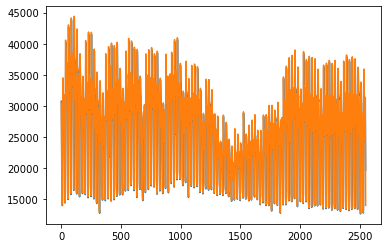

In [327]:
plt.plot(result)
plt.plot(Y_test)

In [328]:
mean_absolute_error(Y_test, regr.predict(X_test))

1975.6072162599205

If you want to put more attention on outliers (huge errors) you can consider the Mean Squared Error (MSE). Like it’s name implies it takes the mean of the squared errors (differences between y and y_hat). Due to its squaring, it heavily weights large errors more than small ones, which can be in some situations a disadvantage. Therefore the MSE is suitable for situations where you really want to focus on large errors. Also keep in mind that due to its squaring the metric loses its unit.

In [329]:
mean_squared_error(Y_test, regr.predict(X_test))

8873959.775056602

## Italy Power Demand

#### MLP ONLINE

#### MLP BATCH

## Power Consumption House


#### MLP ONLINE


#### MLP BATCH


# KNNRegressor online vs batch

## Water Volume Prediction


### KNNRegressor Online

### KNNRegressor Batch

## Italy Power Demand

### KNNRegressor Online

### KNNRegressor Batch

## Power Consumption House

### KNNRegressor Online

### KNNRegressor Batch

# RANDOM FOREST online vs batch

## Water Volume Prediction


### Random Forest Online

### Random Forest Batch

## Italy Power Demand

### Random Forest Online

### Random Forest Batch

## Power Consumption House

### Random Forest Online

### Random Foresr Batch

# DECISION TREE online vs batch

## Water Volume Prediction


### DECISION TREE Online

### DECISION TREE Batch

## Italy Power Demand

### DECISION TREE Online

### DECISION TREE Batch

## Power Consumption House

### DECISION TREE Online

### DECISION TREE Batch